# A first example

In this notebook we consider a simple problem to compare how a simple problem can be approached both analytically (using calculus) and numerically (using mathematical optimization). In this course we will be mostly concerned about the second approach, having to deal with high-dimensional and complex problems for which analytical solutions are beyond reach.

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_ipopt()

pyomo was previously installed
ipopt was previously installed


True

## Alice's rose problem description

Alice receives a beautiful rose but she has only a lemonade glass where to put the rose, which looks quite unstable. Adding a bit of water should help, but too much water will also compromises stabiliity! What is the _optimal_ level of water for her rose on a lemonade glass?

[Archimedes]( https://en.wikipedia.org/wiki/Archimedes) taught us how to compute the _center of gravity_ of the glass with water, which has height
$h = \frac{m_w}{m_w+m_g} h_w + \frac{m_g}{m_w+m_g} h_g$ where
* $m_w$ the mass of water 
* $m_g$ the mass of glass
* $h_w$ the height of the center of gravity of the water in the glass
* $h_g$ the height of the center of gravity of the glass without water 

Since Alice's glass is $20$ cm tall, $4$ cm wide and weighs $100$ gram, Alice may fill the glass with water up to height $x$ cm, provided that $0 \leq x \leq 20$ since the water must fit in the glass.

The volume of water is $\pi r^2 x$ with $r$ the radius of the base, i.e. $r=2$. The volume is therefore $4\pi x$ cubic centimetres. Since the density of water can be [taken](https://en.wikipedia.org/wiki/Gram_per_cubic_centimetre) as being $1$ gram per cubic centimeter we have:

* $m_w = 4\pi x$
* $m_g = 100$
* $h_w = \frac{x}{2}$
* $h_g = \frac{20}{2} = 10$ 

We can then finally obtain the following formula for the height of the center of gravity of the glass with water:

$$
h = \frac{4\pi x}{4\pi x + 100} \frac{x}{2} + \frac{100}{4\pi x + 100} 10 = \frac{4\pi x^2 + 2000}{8\pi x + 200}
$$

The full optimization problem then becomes

$$
\begin{array}{rl}
\min    & \dfrac{4\pi x^2 + 2000}{8\pi x + 200}  \\
s.t.    & x \geq 0   \\
        & x \leq 20  \\
\end{array}
$$

## Analytical solution using sympy and math packages

As you learned in calculus courses, you should know that the minima and maxima of a given differentiable function $h(x)$ should be searched among the stationary points, i.e., the points of the domain where the derivative $h'(x)$ becomes equal to zero. We can do these calculations using the [sympy](https://www.sympy.org/en/index.html) and [math](https://docs.python.org/3/library/math.html) packages. We have two different options, depending on whether we want to treat $\pi$ as a number or as symbol.

### Treating $\pi$ as a number

In [24]:
import sympy
import math

# x is a symbol and pi is a number
x = sympy.Symbol('x')
pi = math.pi

# h(x) is a function of x, and hprime its derivative h'(x)
h = (4*pi*x**2 + 2000)/(8*pi*x+200)
hprime = sympy.diff(h, x)

# calculate the values of x that solve the equatioin h'(x)=0
sol = sympy.solveset(hprime, x)
sol.evalf(6)

{-22.8735, -7.95775, 6.95804}

The equation $h^\prime(x) = 0$ has two solutions in the domain $[0,20]$: one negative and one positive. Obviously, only the positive one $x^* \approx 6.95804$ makes sense in the context of Alice's problem and, since its value is between $0$ and $20$, it is indeed feasible. The sign of the second derivative tells us whether this stationary point is a *maximum*, a *minimum* or a *saddle point*. Since $h^{\prime\prime}(x^*) > 0$ it is indeed a (local) **minimum**.

### Treating $\pi$ as a symbol

In [25]:
# now both x and pi are symbols
pi = sympy.Symbol('pi')

# we redefine h with x and pi as symbols
h = (4*pi*x**2 + 2000)/(8*pi*x + 200)

# calculate the derivative analytically
hprime = sympy.diff(h, x)

# calculate the solutions of h'(x)=0 analytically
solution = sympy.solveset(sympy.diff(h, x), x )
display(solution)

# approximate the numerical value of the positive of the two solutions
s = max(solution.subs(pi, math.pi).evalf(6))
s

{(-5*sqrt(5)*sqrt(4*pi + 5) - 25)/pi, (5*sqrt(5)*sqrt(4*pi + 5) - 25)/pi}

6.95804

Let us visualize the function $h(x)$ and the point $x^*$ that we identified.

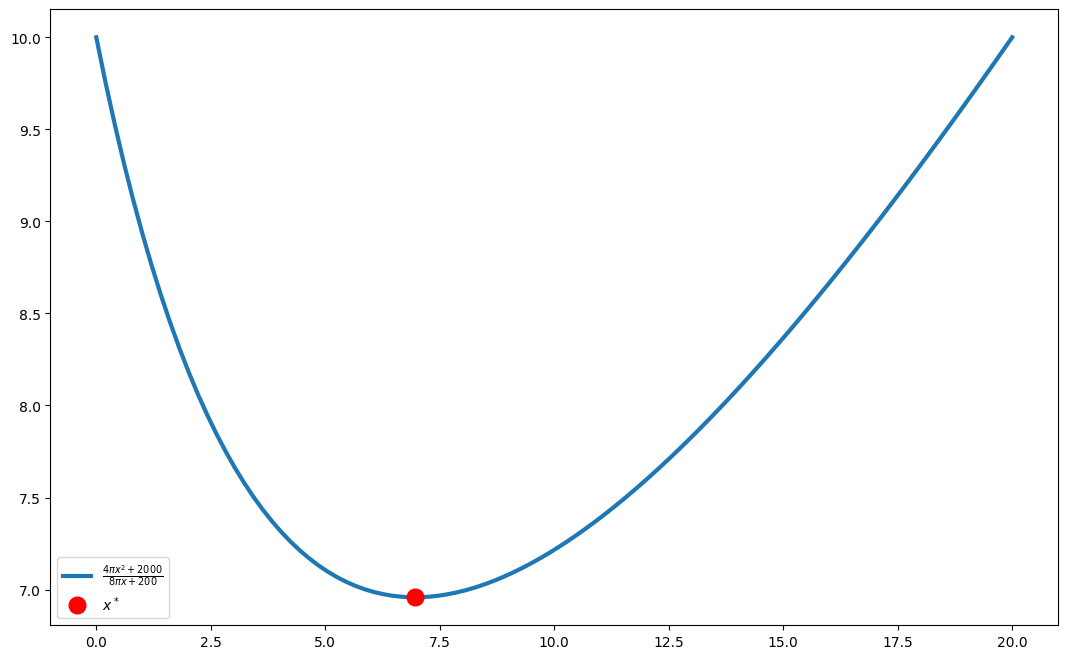

In [31]:
import matplotlib.pyplot as plt
import numpy as np
    
def plot_alice(h, s, start, stop, width=18, height=8):

    plt.rcParams["figure.figsize"] = (13,8)

    x = sympy.Symbol('x')
    f = sympy.lambdify(x, h.subs( pi, math.pi))

    x = np.linspace(start=start,stop=stop,num=100) 
    y = f(x)

    plt.plot(x,y,label='$'+sympy.latex(h)+'$',linewidth=3)
    plt.plot(s,f(s), 'ro', label='$x^*$', markersize=12)

    plt.legend()
    plt.show() 
    
plot_alice( h, s, 0, 20 )

## Beyond the analytical solution

In general, constrained optimization problems have much more involved, complicated, and high-dimensional feasible regions and/or non-differentiable objective functions. For this reason, it makes sense to frame and solve problem differently using techniques from mathematical optimization. The way we implement and numerically solve these optimization problems in Python is using the `Pyomo` package. `Pyomo` has the advantage of completely separating modeling from solving, which allows us to switch solver without recoding a problem to scratch! 

In [33]:
import pyomo.environ as pyo

alice = pyo.ConcreteModel('Alice')
alice.h = pyo.Var(bounds=(0,20))

@alice.Objective(sense=pyo.minimize)
def cog(m):
    return (4*math.pi*alice.h**2 + 2000)/(8*math.pi*alice.h + 200)

alice.pprint()

1 Var Declarations
    h : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :    20 : False :  True :  Reals

1 Objective Declarations
    cog : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : (12.566370614359172*h**2 + 2000)/(25.132741228718345*h + 200)

2 Declarations: h cog


We will use `ipopt` as solver, which is a generic solver for non-linear problems. In case you are using Google Colab, we refer again to [this notebook](https://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/01.02-Running-Pyomo-on-Google-Colab.ipynb) to learn how to run `Pyomo` and how to install solvers on Google Colab. For a complete overview of `Pyomo` please check the [cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook/).

In [34]:
results = pyo.SolverFactory('ipopt').solve(alice)
print("Solver status:",results.solver.status," Solver termination condition:",results.solver.termination_condition )
alice.display()

Solver status: ok  Solver termination condition: optimal
Model Alice

  Variables:
    h : Size=1, Index=None
        Key  : Lower : Value            : Upper : Fixed : Stale : Domain
        None :     0 : 6.95803921230998 :    20 : False : False :  Reals

  Objectives:
    cog : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 6.95803920980307

  Constraints:
    None


## Conclusions

This notebook shows how to solve Alice's problem: finding the most stable amount of water in a vase. 

The notebook shows how to solve the problem analytically with `sympy`, how to use `matplotlib` to visualize the function and the optimum, and how to model Alice's problem using `Pyomo` and solve it with `ipopt`.
